# Hands on Project [CNL 2019-2020]
## Master [MSROE-GEO2]

In this project, you are asked to write the numerical integration of the Frederick Armstrong constitutive relationship [paper](https://github.com/FilLTP89/teaching/blob/master/slides/Frederick_Armstrong_2007.pdf).
The numerical scheme adopted is explicit, according to [Sloan (1987)](https://github.com/FilLTP89/teaching/blob/master/slides/Sloan_1987.pdf).

In the following cells, the main code layout is presented. 
You are asked to add code lines where the tag `[COMPLETE]` appears.

Refer to class slideshows:
  + [lecture 1](https://github.com/FilLTP89/teaching/blob/master/slides/FG_CNL_2019_lecture_1.pdf)
  + [lecture 2](https://github.com/FilLTP89/teaching/blob/master/slides/FG_CNL_2019_lecture_2.pdf)

First, lets setup the main `python` packages required.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline
from IPython.display import Latex, display, Image, HTML 

### 0. Definition of input material parameters

In [0]:
# Shear wave velocity
Vs = 300. #[m/s] 
# Unit volume mass
Ds = 1800 #[kg/m3]
# Poisson's ratio
nu = 0.25 #[1]

# Lamé parameters
mu = Vs**2*Ds #[Pa]
la = 2.*nu*mu/(1.-2.*nu) 

# Non-linear parameters
gel   = 1.E-6 # shear strain elastic limit
syld  = 1.E-6*mu # first yield limit
Ckin  = 3.*mu 
kkin  = 1./(np.sqrt(3.)*(1.0E5-gel))
Rinf  = 1.2*syld
biso  = 10.

# basic tensors
A = np.diagflat([1.,1.,1.,2.,2.,2.]);
A1 = np.diagflat([1.,1.,1.,0.5,0.5,0.5]);
m = np.array([1.,1.,1.,0.,0.,0.])

# tolerances
FTOL = 1E-4
LTOL = 1E-6

### 1.1 Compute the stiffness matrix `Dijhk` within the `NL_elastic_matrix` function [COMPLETE].


In [0]:
# compute the elastic matrices
def NL_elastic_matrix(type='D',mu0=1.,la0=1.,E0=1.,nu0=1.):
    DELijhk = np.zeros((6,6))
    CELijhk = np.zeros((6,6))

    if type.upper()=='D':
        # Stiffness Matrix (6*6)
        print("Stiffness matrix not defined")
        #[COMPLETE] Write the expression of the stiffness matrix
        # use the numpy function tensordot https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.tensordot.html
        #DELijhk = ...
        #return DELijhk
    elif type.upper()=='C':
        # Compliance Matrix (6*6)
        CELijhk=-(nu0/E0)*np.tensordot(m,m,0)+((1+nu0)/E0)*A
        print(np.tensordot(m,m,0))
        return CELijhk
    elif type.upper()=='B':
        # Both matrices
        # Stiffness Matrix (6*6)
        # [COMPLETE] Write the expression of the stiffness matrix 
        # DELijhk=...
        # Compliance Matrix (6*6)
        CELijhk=-(nu0/E0)*np.tensordot(m,m,0)+((1+nu0)/E0)*A
        return DELijhk,CELijhk

#[COMPLETE]
DELijhk,CELijhk = NL_elastic_matrix(type='B',mu0=...,la0=...,E0=...,nu0=...)

### 1.2 Compute spherical and deviatoric part of a tensor with `STST_components` for a generic 2nd order symmetric tensor `WWij`

In [0]:
def STST_components(WWij,coeff):
    # WWij = np.array((6,))
    #
    # _Spherical Part (coeff=3 for stresses, coeff=1 for strain)_
    #
    WP=WWij[0:2].sum()/coeff
    #
    # _Deviatoric Part_
    #
    WDij=WWij-(WWij[0:2].sum()/3.)*m
    return WP, WDij

### 1.3 Compute the J2 invariant (in `STST_equivalent`) and the Von Mises failure criterion and its gradient within `mises_function` [COMPLETE]

In [0]:
def STST_equivalent(Sij,type):
    WWeq = 0.

    # Compute J2 norm for strain and stress    
    if type.lower == 'strain':
        WWeq=sqrt(2.*WWij.dot(WWij)/3.)
    elif type.lower() == 'stress':
        # [COMPLETE] compute the mises criterion for Wij
        # Do not forget to count twice the values of tau_xy,tau_xz,tau_yz
        # Use A matrix
        # WWeq=...
    return WWeq

In [0]:
def mises_function(Sij,Xij,R,syld):
    _,WWDij = STST_components(WWTij,3) # deviator
    # [COMPLETE] compute the mises function
    #f=... # mises function
    # gradient of mises function wrt stress
    M=1.5*A@(WWDij-Xij)/STST_equivalent(WWDij-Xij,'stress') 
    return f,M

### 2.1 Radial return algorithm to find intersection between stress state and failure criterion (`NL_pegasus`) and return the plastic status for a given stress state ($f<0$, $f=0$ or $f>0$). The function provides the percentage $\alpha$ of stress increment that is within the yield locus $f=0$.
$$\underline{\underline{\Delta\sigma}}_n=\alpha\underline{\underline{\Delta\sigma}}_n+(1-\alpha)\underline{\underline{\Delta\sigma}}_n, \quad \alpha\in\left[0,1\right]$$

$$\text{if} f\left(\underline{\underline{\sigma}}_n\right)<0\to f\left(\underline{\underline{\sigma}}_n+\alpha\underline{\underline{\Delta\sigma}}_n\right)=0 $$



In [0]:
def NL_pegasus(Sij,dSij,Xij,R,syld):
    alpha0  = 0
    alpha1  = 1
    stress0 = Sij+alpha0*dSij 
    stress1 = Sij+alpha1*dSij
    
    F0,gradF = mises_function(stress0,Xij,R,syld)
    F1,gradF = mises_function(stress1,Xij,R,syld)
    for i in range(10):
        alpha  = alpha1-F1*(alpha1-alpha0)/(F1-F0)
        stress = NL_update_stress(Sij,alpha*dSij)
        FM,gradF = mises_function(stress,Xij,R,syld)
        
        if np.abs(FM)<=FTOL: # INTERSECTION FOUND
            break
        else:
            if (FM*F0<0):
                alpha1=alpha0
                F1=F0
            else:
                F1 = F1*F0/(FM+F0);
            F0=FM
            alpha0=alpha
    return alpha

### 2.2 Check Karush-Kuhn-Tucker conditions

In [0]:
def NL_kkt(dSij,Sij0,Xij,R,syld):
    alpha_epl = -1.
    flagxit = False
    # PREDICTION
    stress0 = Sij+alpha0*dSij
    stress1 = Sij+alpha1*dSij
    
    FS,gradFS = mises_function(stress0,Xij,R,syld)
    FT,gradFT = mises_function(stress1,Xij,R,syld)
    
    # CHECK KKT CONDITIONS
    
    # purely elastic load
    if FT<=FTOL:
        alpha_epl = 1.
        st_epl    = False
        flagxit   = False

    # elastic-plastic load
    if FS<-FTOL and FT>FTOL:
        st_epl = True
        alpha_epl = NL_pegasus(stress0,dtrial,Xij,R,syld)
        flagxit = True
    
    # plastic load    
    if np.abs(FS)<=FTOL and FT>FTOL:
        checkload = gradFS.dot(dSij)/np.norm(gradFS)/np.norm(dtrial)
        
        # load reversal
        if checkload>=-LTOL:  # PLASTIC LOADING
            alpha_epl = 0.
        else: # PLASTIC UNLOADING
            alpha_epl = NL_pegasus(stress0,dSij,Xij,R,syld)
        st_epl = True
        flagxit = True
    
    # KKT failed
    if not flagxit:
        print('ERROR IN FINDING INTERSECTION')
        exit()
    
    # COMPUTE ON-LOCUS STRESS STATE
    STij_on_F = stress0+alpha_epl*dSij
    return st_epl, STij_on_F, alpha_epl

### 3.1 Compute hardening modulus $H$ [COMPLETE]

In [0]:
def NL_compute_H(Sij,Xij,R,Ckin,kkin,Rinf,biso):
    # COMPUTE HARDENING MODULUS
    F,gradF = mises_function(Sij,Xij,R,syld)
    # isotropic hardening
    # [COMPLETE]
    # h_iso = ...
    
    # kinematic hardening 
    # h_kin = ...
    
    return h_iso+h_kin;

### 3.2 Compute plastic multiplier increment $\delta\lambda_n$

In [0]:
 def NL_compute_plm(dETij,Sij,Xij,R,syld,Ckin,kkin,Rinf,biso,
                DELijhk):
    
    _,M   = mises_function(Sij,Xij,R,syld)  
    h = NL_compute_H(Sij,Xij,R,Ckin,kkin,Rinf,biso)
    # PLASTIC MULTIPLIER
    # [COMPLETE] 
    # dplm = ...
    return dplm

### 3.3 Compute hardening increments $\underline{\underline{\Delta X}}$ and $\Delta R$ [COMPLETE]

In [0]:
def NL_compute_hardening_increment(dplm,ij,Xij,R,syld,Ckin,kkin,Rinf,biso):
    # ISOTROPIC HARDENING
    #[COMPLETE]
    # dR = ...
    
    # KINEMATIC HARDENING
    _,M = mises_function(Sij,Xij,R,syld)
    # [COMPLETE]
    # dXij = ...

    return dXij,dR

### 4.0 Set up main time-marching scheme

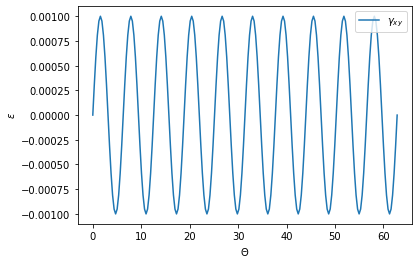

In [18]:
# total strain loading (sinusoidal)
nloops = 10.
dtheta = np.pi/10.
theta = np.arange(0.,nloops*2.*np.pi+dtheta,dtheta)
gxy_max = 1.E-3 # maximum gamma_xy amplitude
ETij = np.zeros((theta.size,6)) # eps_xx,eps_yy,eps_zz,gamma_xy,gamma_xz,gamma_yz
ETij[:,3] = gxy_max*np.sin(theta) #gamma_xy
plt.figure()
plt.plot(theta,ETij[:,3],label='$\gamma_{xy}$')
plt.legend()
plt.xlabel('$\Theta$')
plt.ylabel('$\epsilon$')


EELij = np.zeros((theta.size,6)) # elastic eps_xx,eps_yy,eps_zz,gamma_xy,gamma_xz,gamma_yz
EPLij = np.zeros((theta.size,6)) # plastic eps_xx,eps_yy,eps_zz,gamma_xy,gamma_xz,gamma_yz
STij  = np.zeros((theta.size,6)) # stress sig_xx,sig_yy,sig_zz,tau_xy,tau_xz,tau_yz
Xij   = np.zeros((theta.size,6)) # backstress sig_xx,sig_yy,sig_zz,tau_xy,tau_xz,tau_yz
# total strain state at time tN/tN1
ETijN    = np.zeros((6,))
ETijN1   = ETij[0,:]
# elastic strain state at time tN/tN1
EELijN  = np.zeros((6,))
EELijN1 = np.zeros((6,))
# plastic strain state at time tN/tN1
EPLijN  = np.zeros((6,))
EPLijN1 = np.zeros((6,))
# stress state at time tN/tN1
STijN    = np.zeros((6,))
STijN1   = np.zeros((6,))
# back stress state at time tN/tN1
XijN     = np.zeros((6,))
XijN1    = np.zeros((6,))
# isotropic radius at time tN/tN1
RN       = 0.
RN1      = 0.
# plastic multiplier at time tN/tN1
LambdaN  = 0.
LambdaN1 = 0.
# plastic status at time tN/tN1
st_epl    = False
# sub iterations to go to convergence
nit = 10

### 4.2 Solve the elasto-plastic problem step-by-step [COMPLETE]
Use the function above!

In [0]:
## SOLVING ELASTIC-PLASTIC PROBLEM
for tN in range(1,theta.size):
    # STRAIN UPDATE (tN)
    ETijN  = ETijN1
    EELijN = EELijN1
    EPLijN = EPLijN1
    LambdaN = LambdaN1
    # STRESS UPDATE (tN)
    STijN   = STijN1
    # HARDENING VARIABLES UPDATE (tN)
    XijN    = XijN1
    RN      = RN1
    # update stress state
    STij[tN-1,:] = STijN
    # update elastic strain state
    EELij[tN-1,:] = EELijN
    # update plastic strain state
    EPLij[tN-1,:] = EPLijN
    # update hardening parameters
    Xij[tN-1,:] = XijN
    #
    # _total strain increment (from loading path)_
    #
    dETijN = ETij[tN,:]-ETij[tN-1,:]
    dEPLijN   = np.zeros((6,)) # plastic strain increment at tN
    #
    # _trial increment (purely elastic)_
    #
    dSTijNt = DELijhk@dETijN 
    #
    # _plasticity check_
    #
    st_epl,STijN_on_F,alphaNL = NL_kkt(dSTijNt,STijN,XijN,RN,syld)
    #
    # _plastic correction_
    #
    if st_epl:
        # residual strain increment for elasto-plastic loading
        dETalphaN = (1.-alphaNL)*dETijN
        Sij1 = STijN
        Xij1 = XijN
        R1   = RN
        plm1 = 0
        for i in range(nit): # sub-iteration
            #
            # _prediction_
            #
            Sij0 = Sij1 
            Xij0 = Xij1 
            R0   = R1
            plm0 = plm1
            _,M0 = mises_function(Sij0,Xij0,R0,syld)
        
            # COMPUTE PLASTIC MULTIPLIER
            # [COMPLETE]
            dplm = NL_compute_plm(dETalphaN,Sij0,Xij0,R0,syld,
                              Ckin,kkin,Rinf,biso,DELijhk)
            dEPLijN = dEPLijN+dplm*M0
            plm1 = plm0+dplm
        
            # ELASTIC-PLASTIC CORRECTION
            #
            # increments of hardening parameters
            #
            # [COMPLETE]
            dXij0,dR0 = NL_compute_hardening(dplm,Sij0,R0,Xij0,
                                             syld,Ckin,kkin,plm0,psi,omega,Rinf,biso)
            #
            # update
            #
            Xij1 = Xij0+dXij0
            R1   = R0+dR0
            Sij1 = Sij0+DELijhk@(dETalphaN-dplm*M0)
            F_check,M0 = mises_function(Sij1,Xij1,R1,syld)
        
            # DRIFT CORRECTION
            if np.abs(F_check)>FTOL:
                F,_=mises_function(Sij1,Xij1,R1,syld);
                h = NL_compute_H(Sij,Xij1,R1,Ckin,kkin,Rinf,biso)
                dalpha=-F/(h+M0.dot(DELijhk@M0))
                dSij = dalpha*DELijhk@M0
                dXij,dR = NL_compute_hardening(dalpha,Sij1,R1,Xij1)
                Sij1 = Sij1+dSij
                Xij1=Xij1+dXij
                R1=R1+dR
                dEPLijN = dEPLijN-dalpha*M0
    else:
        STijN1 = STijN_on_F
        XijN1  = XijN
        RN1    = RN
        dEPLijN= np.zeros((6,))
        #
        # _update final state_
        #
        ETijN1   = ETijN   + dETijN
        ETELijN1 = ETELijN + (STijN1-STijN)*CELijhk
        ETPLijN1 = ETPLijN + dETijPL


### 5. Plot the strain-stress relationship (the xy component - only non-zero component)